In [48]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np

In [49]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [50]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


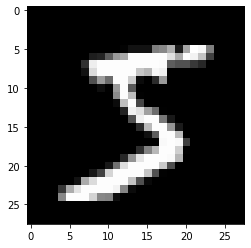

Label: 5
Flatten size: 784


In [51]:
pyplot.imshow(train_X[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Label: {}".format(train_y[0]))
print("Flatten size: {}".format(len(train_X[0].flatten())))

In [52]:
!git clone https://github.com/data61/python-paillier

Cloning into 'python-paillier'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 997 (delta 5), reused 0 (delta 0), pack-reused 984
Receiving objects: 100% (997/997), 281.07 KiB | 6.69 MiB/s, done.
Resolving deltas: 100% (637/637), done.


In [53]:
!apt-get install libgmp-dev
!apt-get install libmpfr-dev
!apt-get install libmpc-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgmp-dev is already the newest version (2:6.1.2+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmpfr-dev is already the newest version (4.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmpc-dev is already the newest version (1.1.0-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [54]:
!pip3 install -r /content/python-paillier/requirements.txt

In [55]:
!python /content/python-paillier/setup.py build

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:461: UserWarning: Normalizing '1.4.1-dev0' to '1.4.1.dev0'
  warnings.warn(tmpl.format(**locals()))
running build
running build_py
creating build
creating build/lib
creating build/lib/phe
copying phe/encoding.py -> build/lib/phe
copying phe/util.py -> build/lib/phe
copying phe/__init__.py -> build/lib/phe
copying phe/paillier.py -> build/lib/phe
copying phe/__about__.py -> build/lib/phe
copying phe/command_line.py -> build/lib/phe
creating build/lib/phe/tests
copying phe/tests/cli_test.py -> build/lib/phe/tests
copying phe/tests/math_test.py -> build/lib/phe/tests
copying phe/tests/util_test.py -> build/lib/phe/tests
copying phe/tests/paillier_test.py -> build/lib/phe/tests
copying phe/tests/__init__.py -> build/lib/phe/tests


In [56]:
!python /content/python-paillier/setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:461: UserWarning: Normalizing '1.4.1-dev0' to '1.4.1.dev0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
creating phe.egg-info
writing phe.egg-info/PKG-INFO
writing dependency_links to phe.egg-info/dependency_links.txt
writing entry points to phe.egg-info/entry_points.txt
writing requirements to phe.egg-info/requires.txt
writing top-level names to phe.egg-info/top_level.txt
writing manifest file 'phe.egg-info/SOURCES.txt'
writing manifest file 'phe.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/phe
copying build/lib/phe/encoding.py -> build/bdist.linux-x86_64/egg/phe
copying build/lib/phe/util.py -> build/bdist.linux-x86_64/egg/phe
copying build/lib/phe/__init__.py -> build/bdist.linux-x86_64/egg/phe
creating

In [57]:
%cd /content/python-paillier/

/content/python-paillier


In [74]:
import numpy as np
from sklearn.datasets import load_diabetes

import phe as paillier

seed = 43
np.random.seed(seed)

def get_data(n_clients):
    """
    Import the dataset via sklearn, shuffle and split train/test.
    Return training, target lists for `n_clients` and a holdout test set
    """
    print("Loading MNIST data")
    diabetes = load_diabetes()
    #y = diabetes.target
    #X = diabetes.data

    

    (X, y), (test_X, test_y) = mnist.load_data()
    
    tmp = []

    for rr in X:
      tmp.append(rr.flatten())

    X = tmp

    # Reiktu pakeiti list => array ir lyginti dimensijas
    # jos turetu sutapti, kad nebutu klaidu

    print(X.shape)
    
    # Add constant to emulate intercept
    #X = np.c_[X, np.ones(X.shape[0])]

    # The features are already preprocessed
    # Shuffle
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm, :], y[perm]

    # Select test at random
    test_size = 50
    test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
    train_idx = np.ones(X.shape[0], dtype=bool)
    train_idx[test_idx] = False
    X_test, y_test = X[test_idx, :], y[test_idx]
    X_train, y_train = X[train_idx, :], y[train_idx]

    # Split train among multiple clients.
    # The selection is not at random. We simulate the fact that each client
    # sees a potentially very different sample of patients.
    X, y = [], []
    step = int(X_train.shape[0] / n_clients)
    for c in range(n_clients):
        X.append(X_train[step * c: step * (c + 1), :])
        y.append(y_train[step * c: step * (c + 1)])

    print(X[0][0])

    return X, y, X_test, y_test

def mean_square_error(y_pred, y):
    """ 1/m * \sum_{i=1..m} (y_pred_i - y_i)^2 """
    return np.mean((y - y_pred) ** 2)


def encrypt_vector(public_key, x):
    return [public_key.encrypt(i) for i in x]


def decrypt_vector(private_key, x):
    return np.array([private_key.decrypt(i) for i in x])


def sum_encrypted_vectors(x, y):
    if len(x) != len(y):
        raise ValueError('Encrypted vectors must have the same size')
    return [x[i] + y[i] for i in range(len(x))]


class Server:
    """Private key holder. Decrypts the average gradient"""

    def __init__(self, key_length):
         keypair = paillier.generate_paillier_keypair(n_length=key_length)
         self.pubkey, self.privkey = keypair

    def decrypt_aggregate(self, input_model, n_clients):
        return decrypt_vector(self.privkey, input_model) / n_clients


class Client:
    """Runs linear regression with local data or by gradient steps,
    where gradient can be passed in.
    Using public key can encrypt locally computed gradients.
    """

    def __init__(self, name, X, y, pubkey):
        self.name = name
        self.pubkey = pubkey
        self.X, self.y = X, y
        self.weights = np.zeros(X.shape[1])
        self.predictionTreshold = 50

    def fit(self, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient()
            self.gradient_step(gradient, eta)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def compute_gradient(self):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(self.X) - self.y
        return delta.dot(self.X) / len(self.X)

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

    def encrypted_gradient(self, sum_to=None):
        """Compute and encrypt gradient.
        When `sum_to` is given, sum the encrypted gradient to it, assumed
        to be another vector of the same size
        """
        gradient = self.compute_gradient()
        encrypted_gradient = encrypt_vector(self.pubkey, gradient)

        if sum_to is not None:
            return sum_encrypted_vectors(sum_to, encrypted_gradient)
        else:
            return encrypted_gradient

    def analyze_data_privacy(self, X, Y):
      predicted = 0
      notPredicted = 0
      
      # Data that has been predicted correctly
      predictedDataX = []
      predictedDataY = []

      # Checking model's accuracy
      for i in range(len(X)):
        prediction = self.predict(X[i])

        if(prediction >= Y[i] - self.predictionTreshold and prediction <= Y[i] + self.predictionTreshold):
          predicted += 1
          
          predictedDataX.append(X[i])
          predictedDataY.append(Y[i])
        else:
          notPredicted += 1

      print("Predicted: {} Not predicted: {}".format(predicted/(predicted+notPredicted)*100, notPredicted/(predicted+notPredicted)*100))

      # Skaiciuojamas vidutinis maksimalus modelio epsilonas
      increaseValues = np.repeat(0, 10)
      dataIdxArr = np.repeat(1, 10)

      for dataIdx in range(len(predictedDataX)):
        for collumnIdx in range(len(X[0])):
          label = predictedDataY[dataIdx]
          data = predictedDataX[dataIdx]

          y_prediction = self.predict(data)

          if y_prediction >= label - self.predictionTreshold and y_prediction <= label + self.predictionTreshold:
            epsilon = 0.1
            increase = 0

            dataIdxArr[collumnIdx] += 1

            while((y_prediction >= label - self.predictionTreshold and y_prediction <= label + self.predictionTreshold) and increase < 100):
              tempData = data
              increase += epsilon
              tempData[collumnIdx] += increase

              y_prediction = self.predict(tempData)

            increaseValues[collumnIdx] += increase
        
      # Showing output
      for i in range(len(dataIdxArr)):
        print("{}th collumn maximum epsilon: {}".format(i, increaseValues[i]/dataIdxArr[i]))

      s = 0
      for i in range(10):
        s += increaseValues[i]/dataIdxArr[i]

      print("Model maximum epsilon: {}".format(s/10))
      print("Model treshold: {}".format(self.predictionTreshold))

def federated_learning(X, y, X_test, y_test, config):
    n_clients = config['n_clients']
    n_iter = config['n_iter']
    names = ['Hospital {}'.format(i) for i in range(1, n_clients + 1)]

    # Instantiate the server and generate private and public keys
    # NOTE: using smaller keys sizes wouldn't be cryptographically safe
    server = Server(key_length=config['key_length'])

    # Instantiate the clients.
    # Each client gets the public key at creation and its own local dataset
    clients = []
    for i in range(n_clients):
        clients.append(Client(names[i], X[i], y[i], server.pubkey))

    # The federated learning with gradient descent
    print('Running distributed gradient aggregation for {:d} iterations'
          .format(n_iter))
    for i in range(n_iter):

        # Compute gradients, encrypt and aggregate
        encrypt_aggr = clients[0].encrypted_gradient(sum_to=None)
        for c in clients[1:]:
            encrypt_aggr = c.encrypted_gradient(sum_to=encrypt_aggr)

        # Send aggregate to server and decrypt it
        aggr = server.decrypt_aggregate(encrypt_aggr, n_clients)

        # Take gradient steps
        for c in clients:
            c.gradient_step(aggr, config['eta'])

    print('Error (MSE) that each client gets after running the protocol:')
    for c in range(len(clients)):
        y_pred = clients[c].predict(X_test)
        mse = mean_square_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(clients[c].name, mse))

        # Analyze client's data privacy
        clients[c].analyze_data_privacy(X[c], y[c])

def local_learning(X, y, X_test, y_test, config):
    n_clients = config['n_clients']
    names = ['Hospital {}'.format(i) for i in range(1, n_clients + 1)]

    # Instantiate the clients.
    # Each client gets the public key at creation and its own local dataset
    clients = []
    for i in range(n_clients):
        clients.append(Client(names[i], X[i], y[i], None))

    # Each client trains a linear regressor on its own data
    print('Error (MSE) that each client gets on test set by '
          'training only on own local data:')
    for c in range(len(clients)):
        clients[c].fit(config['n_iter'], config['eta'])
        y_pred = clients[c].predict(X_test)
        mse = mean_square_error(y_pred, y_test)

        print('{:s}:\t{:.2f}'.format(clients[c].name, mse))

        # Analyze client's data privacy
        clients[c].analyze_data_privacy(X[c], y[c])

if __name__ == '__main__':
    config = {
        'n_clients': 1,
        'key_length': 1024,
        'n_iter': 2000,
        'eta': 1.0,
    }

    X, y, X_test, y_test = get_data(n_clients=config['n_clients'])

    local_learning(X, y, X_test, y_test, config)

    #federated_learning(X, y, X_test, y_test, config)

Loading MNIST data


AttributeError: ignored